In [27]:
# устанка catboost
pip install catboost

     |████████████████████████████████| 76.1 MB 1.3 MB/s 


In [158]:
# импортируем нужные библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [159]:
# загрузим данные
df = pd.read_csv('dataset.csv')

**Описание дата-сета:**

- Well_id — уникальный идентификатор скважины.

- Reservoir pressure — давление жидкости в пласте, [давление].

- ISIP (Instantaneous Shut-In Pressure) — давление жидкости после
мини-ГРП5, [давление].

- Closure Pressure — давление жидкости, когда трещина полностью
     закрывается, [давление].

- PAD Volume — объем чистой жидкости, закачанной в трещину, [объем].

- Fluid Efficiency — эффективность жидкости гидроразрыва (вычисляется
     как отношение объема трещины к объему закачанной жидкости), [0-1].

- Transmissibility (пропускная способность) — коэффициент,
     характеризующий сопротивление жидкости течению через пласт.
- Total Prop Mass — общая масса закачанного проппанта во время
     основной обработки, [масса].

- Max Prop Conc — максимальная концентрация проппанта во время
     основной обработки, [концентрация].

In [160]:
df

,Well_id,Reservoir Pressure,ISIP,Closure Pressure,PAD Volume,Fluid Efficiency,Transmissibility,Total Prop Mass,Max Prop Conc
0,0,1250.50,2129.5,1861.0,4.892,0.149,12.685,16787.317,7.0
1,2,946.75,2850.5,2413.5,5.005,0.240,10.236,14543.000,5.0
2,3,1515.00,3782.5,3054.5,4.995,0.100,10.667,14366.000,5.0
3,4,2390.55,3449.5,3048.0,4.457,0.040,10.765,15406.000,5.0
4,8,655.95,NaN,2290.0,3.563,0.080,12.254,15504.917,7.0
5,9,1837.95,4592.5,3053.0,4.988,0.360,10.404,14162.417,5.0
6,10,927.00,3503.0,2331.0,4.404,0.290,10.986,16674.917,5.0
7,11,1634.70,3758.5,2694.5,4.988,0.020,12.067,12597.417,5.0
8,12,1318.15,4253.0,3202.5,4.628,0.160,10.248,11694.583,5.0
9,13,1140.40,3062.0,2369.0,4.454,0.090,13.169,15655.500,5.0


В целевой переменной **Total Prop Mass** есть пропуски, отложим их в тестовую выборку:

In [166]:
# обучающая выборка
df_train = df[~df['Total Prop Mass'].isna()]

# тестовая выборка
df_test = df[df['Total Prop Mass'].isna()]

# удалим колонку целевой переменной из тестовой выборки
df_test.drop(['Total Prop Mass', 'Well_id'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [167]:
df_train.shape, df_test.shape

((43, 9), (5, 7))

In [168]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43 entries, 0 to 47
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Well_id             43 non-null     int64  
 1   Reservoir Pressure  43 non-null     float64
 2   ISIP                40 non-null     float64
 3   Closure Pressure    41 non-null     float64
 4   PAD Volume          43 non-null     float64
 5   Fluid Efficiency    43 non-null     float64
 6   Transmissibility    43 non-null     float64
 7   Total Prop Mass     43 non-null     float64
 8   Max Prop Conc       43 non-null     float64
dtypes: float64(8), int64(1)
memory usage: 3.4 KB


В датасете 48 наблюдений и 9 колонок, все в числовом формате.

# Задание 1: Заполни все недостающие данные.

In [169]:
# пропуски в датасете
df_train.isna().mean().sort_values(ascending=False)

ISIP                  0.069767
Closure Pressure      0.046512
Well_id               0.000000
Reservoir Pressure    0.000000
PAD Volume            0.000000
Fluid Efficiency      0.000000
Transmissibility      0.000000
Total Prop Mass       0.000000
Max Prop Conc         0.000000
dtype: float64

Видим пропуски в двух признаках:

- ISIP ~ 6%;
- Closure Pressure ~ 4%.

Заполним пропуски. Для этого используем простой, но очень эффективный алгоритм: **KNN Imputer**.

Для оптимизации модели, переберем в итерации несколько 'k' и на каждом шаге будем обучать XGBRegressor и прогнозировать 'Total Prop Mass'. Модель с наименьшей ошибкой и будет соответсвовать оптимальному 'k'.

In [170]:
def optimize_k(dataframe, target):
  """
  Поиск оптимального k для KNNImputer

  :param dataframe: pd.DataFrame, датафрейм, на котором будет обучаться модель
  :param target: str, название целевой переменной
  :return: list, список словарей с k и ошибкой модели
  """
  errors = []
  for k in range(1, 21, 2):
    # инициализация и применение модели к данным
    imputer = KNNImputer(n_neighbors=k)
    imputed = imputer.fit_transform(dataframe)
    # трансформируем данные обратно в датафрейм
    df = pd.DataFrame(imputed, columns=dataframe.columns)

    # разбиваем данные на тренировочную и валидационную выборку
    X_train, X_val, y_train, y_val = train_test_split(df.drop(target, axis=1),
                                                      df[target],
                                                      random_state=23)
    # иинциализируем xgboost и обучаем модель
    x = XGBRegressor(random_state=23)
    x.fit(X_train, y_train)
    # прогноз валидационной выборки
    pred = x.predict(X_val)
    # ошибка модели
    mape = mean_absolute_percentage_error(y_val, pred)
    # добавляем в список ошибок k и соответсвующую ей ошибку
    errors.append(({'k': k, 'MAPE': mape}))


  return errors

In [ ]:
errors = optimize_k(df, 'Total Prop Mass')

In [172]:
errors

[{'MAPE': 2.1015862494749435, 'k': 1},
 {'MAPE': 1.8911976002327189, 'k': 3},
 {'MAPE': 1.9118933426625386, 'k': 5},
 {'MAPE': 1.905202177113324, 'k': 7},
 {'MAPE': 1.9678472865888514, 'k': 9},
 {'MAPE': 1.9209157603616573, 'k': 11},
 {'MAPE': 1.8680140057419512, 'k': 13},
 {'MAPE': 1.8962602771909198, 'k': 15},
 {'MAPE': 1.9113803751645448, 'k': 17},
 {'MAPE': 1.9066216787893364, 'k': 19}]

Оптимальное 'k' = 3.

Заполним пропуски:

In [136]:
# иинциализация модели
imputer = KNNImputer(n_neighbors=3)
# применим модель
imputed = imputer.fit_transform(df_train)
# конвертируем в датафрейм
df_train_imp = pd.DataFrame(imputed, columns=df_train.columns)

# Задание 2: Проверь гипотезу о связи данных.

Наш коллега, занимающийся созданием планов проведения работ по гидроразрыву пласта, однажды поделился своим эмпирическим правилом (rule of thumb): чем больше давление в резервуаре, тем больше надо закачать в трещину проппана.

- Проверим так ли это на самом деле, применив критерий Спирмена, так как он не требует нормальности данных.

In [137]:
# критерий Спирмена
stats.spearmanr(df_train_imp['Reservoir Pressure'], df_train_imp['Total Prop Mass'])

SpearmanrResult(correlation=-0.18317728782845064, pvalue=0.23969114977857986)

- видим, что критерий уверенно принимает нулевую гипотезу, о том, что корелляция между двумя наблюдениями незначима, следовательно взаимозависимости между давлением в резеурвуаре и количеством пропана, требуемого к закачке, **нет**.

Посмотрим, есть ли в датасете характеристики, которые сильно взаимосвязаны:

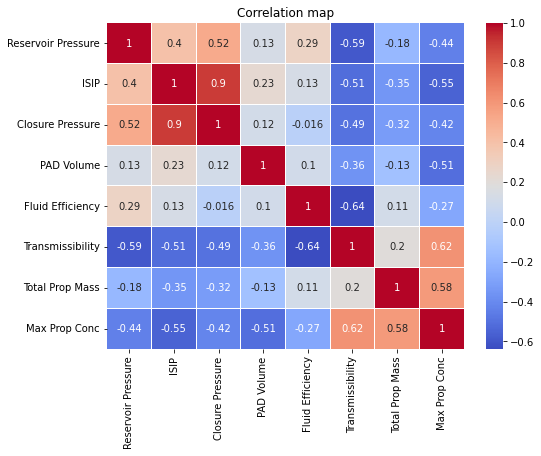

In [138]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_train_imp.drop('Well_id', axis=1).corr(method='spearman'), annot=True, linewidths=0.005, cmap='coolwarm')
plt.title('Correlation map')
plt.show()

- Весьма высокая корреляция наблюдается между **ISIP**(давление жидкости после мини-ГРП) и **Closure Pressure**(давление жидкости, когда трещина полностью закрывается)

Проверим ее значимость:

In [139]:
# критерий Спирмена
stats.spearmanr(df_train_imp['ISIP'], df_train_imp['Closure Pressure'])

SpearmanrResult(correlation=0.9036544850498339, pvalue=1.0833260545810864e-16)

- критерий уверенно отвергает нулевую гипотезу о том, что корелляция между двумя наблюдениями незначима, следовательно между **ISIP** и Closure **Pressure** действительно очень высокая взаимосвязь.

# Задание 3: Натренируй модель машинного обучения.

Опираясь на имеющиеся данные, построй модель для предсказания массы проппанта **Total
Prop Mass** и оцени ее точность.


Обучим XGBRegressor и СatBoostRegressor и усредним их прогноз.

Проверим, нет ли в данных дупликатов:

In [140]:
duplicates = df_train_imp.duplicated().sum()

print(f'В датасете {duplicates} дупликатов.')

В датасете 0 дупликатов.


Посмотрим на распределение целевой переменной:

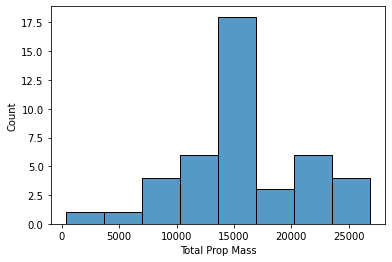

In [141]:
sns.histplot(df_train_imp['Total Prop Mass'])
plt.show()

- распределение целевой переменной не похоже на нормальное, проверим это, применив критерии Шапиро-Уилка и Харке-Бера:

In [142]:
# критерий Шапиро-Уилка
stat, p_value = stats.shapiro(df_train_imp['Total Prop Mass'])

print(f'Статистика: {stat}, p_value: {p_value}')

Статистика: 0.96145099401474, p_value: 0.15664900839328766


In [143]:
# критерий Харке-Бера
stat, p_value = stats.jarque_bera(df_train_imp['Total Prop Mass'])

print(f'Статистика: {stat}, p_value: {p_value}')

Статистика: 0.05937375660952339, p_value: 0.9707494486778364


- Оба теста уверенно приняли нулевую гипотезу, что распределение целевой переменной - нормальное, поэтому мы не будем ее логарифмировать для обучения модели.

In [144]:
# разобьем датасет на обучающую и валидационную выборки
train = df_train_imp.drop(['Well_id', 'Total Prop Mass'], axis=1)
y = df_train_imp['Total Prop Mass']

X_train, X_val, y_train, y_val = train_test_split(train, y, train_size=0.8, random_state=123)

In [145]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((34, 7), (9, 7), (34,), (9,))

### XGBRegressor:

In [146]:
# инициализация
x = XGBRegressor(n_estimators=300, max_depth=8, random_state=23)

# обучение
x.fit(X_train, y_train)

# прогноз валидационной выборки
xgb_predict_val = x.predict(X_val)

# оценка модели
xgb_mape = mean_absolute_percentage_error(y_val, xgb_predict_val)
xgb_mae = mean_absolute_error(y_val, xgb_predict_val)

print(f'\nMAPE xgboost на валидационной выборке: {xgb_mape}')
print(f'MAE xgboost на валидационной выборке: {xgb_mae}')

[10:06:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

MAPE xgboost на валидационной выборке: 0.1187532120473023
MAE xgboost на валидационной выборке: 1810.1937925347224


Видим, что XGBRegressor в среднем ошибается на 11.87%, что неплохой результат.

### CatBoostRegressor:

In [147]:
# инициализация
cb = CatBoostRegressor(iterations=170, max_depth=8,  random_state=23, verbose=False)

# обучение
cb.fit(X_train, y_train)

# прогноз валидационной выборки
cb_predict_val = cb.predict(X_val)

# оценка модели
cb_mape = mean_absolute_percentage_error(y_val, cb_predict_val)
cb_mae = mean_absolute_error(y_val, cb_predict_val)

print(f'MAPE catboost на валидационной выборке: {cb_mape}')
print(f'MAE catboost на валидационной выборке: {cb_mae}')

MAPE catboost на валидационной выборке: 0.09908682744287606
MAE catboost на валидационной выборке: 1451.989876578883


CatBoostRegressor в среднем ошибается на 9.90%, что почти на 2% лучше чем XGBRegressor.

Объединим два алгоритма:

In [148]:
# объединение двух прогнозов
total_predict_val = (xgb_predict_val + cb_predict_val) / 2

# MAPE после объединения
total_mape = mean_absolute_percentage_error(y_val, total_predict_val)

print(f'MAPE после объединения двух алгоритмов: {total_mape}')

MAPE после объединения двух алгоритмов: 0.0913265959434874


Объединение двух алгоритмов позволило **улучшить** метрику на валидационной выборке еще на 0.77%.

### Прогноз тестовой выборки:

In [149]:
# xgboostregressor
xgb_predict_test = x.predict(df_test)

# catboostregressor
cb_predict_test = cb.predict(df_test)

# объединенный прогноз
test_prediction = (xgb_predict_test + cb_predict_test) / 2

print(test_prediction)

[15134.70724829 20686.03059998 21160.60976884 11831.81973288
 18100.03571718]
